# Libraries

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.layers import Dense, ReLU
from tensorflow.keras.layers import Embedding, BatchNormalization, Concatenate
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

import gdown

In [93]:
train_file_id = '1H0FaOmcYD5LX5DxxmPhdFVS-sKPQGP0B'
train_output_file = '/content/train.csv'
train_download_url = f'https://drive.google.com/uc?id={train_file_id}'
gdown.download(train_download_url, train_output_file, quiet=False, fuzzy = True)
df_train = pd.read_csv(train_output_file, sep = ';', header = None, names = ['sentence', 'label'])

train_file_id = '1z_-kGkHq6mTvsANAAnVblIGDcotfPznh'
train_output_file = '/content/test.csv'
train_download_url = f'https://drive.google.com/uc?id={train_file_id}'
gdown.download(train_download_url, train_output_file, quiet=False, fuzzy = True)
df_test = pd.read_csv(train_output_file, sep = ';', header = None, names = ['sentence', 'label'])

train_file_id = '1pfKT28xbIH89dFCEmX1D_R8fuukEfu_a'
train_output_file = '/content/val.csv'
train_download_url = f'https://drive.google.com/uc?id={train_file_id}'
gdown.download(train_download_url, train_output_file, quiet=False, fuzzy = True)
df_val = pd.read_csv(train_output_file, sep = ';', header = None, names = ['sentence', 'label'])

Downloading...
From: https://drive.google.com/uc?id=1H0FaOmcYD5LX5DxxmPhdFVS-sKPQGP0B
To: /content/train.csv
100%|██████████| 1.66M/1.66M [00:00<00:00, 165MB/s]
Downloading...
From: https://drive.google.com/uc?id=1z_-kGkHq6mTvsANAAnVblIGDcotfPznh
To: /content/test.csv
100%|██████████| 207k/207k [00:00<00:00, 59.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1pfKT28xbIH89dFCEmX1D_R8fuukEfu_a
To: /content/val.csv
100%|██████████| 204k/204k [00:00<00:00, 57.2MB/s]


In [94]:
df_train.head()

,sentence,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [95]:
df_train = df_train[~df_train['label'].str.contains('love')]
df_train = df_train[~df_train['label'].str.contains('surprise')]
joy = df_train[df_train['label'] == 'joy'].sample(n=2200, random_state=20)
sad = df_train[df_train['label'] == 'sadness'].sample(n=2200, random_state=20)
fear = df_train[df_train['label'] == 'fear'].sample(n=1937, random_state=20)
anger = df_train[df_train['label'] == 'anger'].sample(n=2159, random_state=20)

df_sampled = pd.concat([joy, sad, fear, anger])

df_train = df_sampled.sample(frac=1, random_state=20).reset_index(drop=True)

In [96]:
df_test.head()

,sentence,label
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness


In [97]:
df_test = df_test[~df_test['label'].str.contains('love')]
df_test = df_test[~df_test['label'].str.contains('surprise')]
joy = df_test[df_test['label'] == 'joy'].sample(n=250, random_state=20)
sad = df_test[df_test['label'] == 'sadness'].sample(n=250, random_state=20)
fear = df_test[df_test['label'] == 'fear'].sample(n=224, random_state=20)
anger = df_test[df_test['label'] == 'anger'].sample(n=275, random_state=20)

df_sampled = pd.concat([joy, sad, fear, anger])

df_test = df_sampled.sample(frac=1, random_state=20).reset_index(drop=True)

In [98]:
df_val.head()

,sentence,label
0,im feeling quite sad and sorry for myself but ...,sadness
1,i feel like i am still looking at a blank canv...,sadness
2,i feel like a faithful servant,love
3,i am just feeling cranky and blue,anger
4,i can have for a treat or if i am feeling festive,joy


In [99]:
df_val = df_val[~df_val['label'].str.contains('love')]
df_val = df_val[~df_val['label'].str.contains('surprise')]
joy = df_val[df_val['label'] == 'joy'].sample(n=250, random_state=20)
sad = df_val[df_val['label'] == 'sadness'].sample(n=250, random_state=20)
fear = df_val[df_val['label'] == 'fear'].sample(n=212, random_state=20)
anger = df_val[df_val['label'] == 'anger'].sample(n=275, random_state=20)

df_sampled = pd.concat([joy, sad, fear, anger])

df_val = df_sampled.sample(frac=1, random_state=20).reset_index(drop=True)

## Train Test Split

In [100]:
tr_text = df_train['sentence']
tr_label = df_train['label']

val_text = df_val['sentence']
val_label = df_val['label']

ts_text = df_test['sentence']
ts_label = df_test['label']

## Encoding

In [101]:
encoder = LabelEncoder()
tr_label = encoder.fit_transform(tr_label)
val_label = encoder.transform(val_label)
ts_label = encoder.transform(ts_label)

## Text preprocessing

In [102]:
max_len = 50

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(tr_text)

sequences = tokenizer.texts_to_sequences(tr_text)
tr_x = pad_sequences(sequences, maxlen=max_len)
tr_y = to_categorical(tr_label)

sequences = tokenizer.texts_to_sequences(val_text)
val_x = pad_sequences(sequences, maxlen=max_len)
val_y = to_categorical(val_label)

sequences = tokenizer.texts_to_sequences(ts_text)
ts_x = pad_sequences(sequences, maxlen=max_len)
ts_y = to_categorical(ts_label)

# DEEP LEARNING

In [103]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, BatchNormalization, Concatenate, ReLU
from tensorflow.keras.models import Model

max_words = 20000
embedding_dim = 50
max_len = 50

branch1_input = Input(shape=(max_len,))
branch1 = Embedding(max_words, embedding_dim)(branch1_input)
branch1 = Conv1D(64, 3, padding='same', activation='relu')(branch1)
branch1 = BatchNormalization()(branch1)
branch1 = ReLU()(branch1)
branch1 = Dropout(0.5)(branch1)
branch1_output = GlobalMaxPooling1D()(branch1)

branch2_input = Input(shape=(max_len,))
branch2 = Embedding(max_words, embedding_dim)(branch2_input)
branch2 = Conv1D(64, 3, padding='same', activation='relu')(branch2)
branch2 = BatchNormalization()(branch2)
branch2 = ReLU()(branch2)
branch2 = Dropout(0.5)(branch2)
branch2_output = GlobalMaxPooling1D()(branch2)

concatenated = Concatenate()([branch1_output, branch2_output])
hid_layer = Dense(128, activation='relu')(concatenated)
dropout = Dropout(0.3)(hid_layer)
output_layer = Dense(4, activation='softmax')(dropout)

model = Model(inputs=[branch1_input, branch2_input], outputs=output_layer)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10            │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_11            │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_14 (Embedding)  │ (None, 100, 50)        │      1,000,000 │ input_layer_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_15 (Embedding)  │ (None, 100, 50)        │      1,000,000 │ input_layer_11[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_14 (Conv1D)        │ (None, 100, 64)        │          9,664 │ embedding_14[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_15 (Conv1D)        │ (None, 100, 64)        │          9,664 │ embedding_15[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_14    │ (None, 100, 64)        │            256 │ conv1d_14[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_15    │ (None, 100, 64)        │            256 │ conv1d_15[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_14 (ReLU)           │ (None, 100, 64)        │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_15 (ReLU)           │ (None, 100, 64)        │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_19 (Dropout)      │ (None, 100, 64)        │              0 │ re_lu_14[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_20 (Dropout)      │ (None, 100, 64)        │              0 │ re_lu_15[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_14   │ (None, 64)             │              0 │ dropout_19[0][0]       │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_15   │ (None, 64)             │              0 │ dropout_20[0][0]       │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_7             │ (None, 128)            │              0 │ global_max_pooling1d_… │
│ (Concatenate)             │                        │                │ global_max_pooling1d_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 128)            │         16,512 │ concatenate_7[0][0]    │
├──────────────────────

 Total params: 2,036,868 (7.77 MB)

 Trainable params: 2,036,612 (7.77 MB)

 Non-trainable params: 256 (1.00 KB)

In [104]:
model.compile(optimizer='adamax',
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10            │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_11            │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_14 (Embedding)  │ (None, 100, 50)        │      1,000,000 │ input_layer_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_15 (Embedding)  │ (None, 100, 50)        │      1,000,000 │ input_layer_11[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_14 (Conv1D)        │ (None, 100, 64)        │          9,664 │ embedding_14[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_15 (Conv1D)        │ (None, 100, 64)        │          9,664 │ embedding_15[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_14    │ (None, 100, 64)        │            256 │ conv1d_14[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_15    │ (None, 100, 64)        │            256 │ conv1d_15[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_14 (ReLU)           │ (None, 100, 64)        │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_15 (ReLU)           │ (None, 100, 64)        │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_19 (Dropout)      │ (None, 100, 64)        │              0 │ re_lu_14[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_20 (Dropout)      │ (None, 100, 64)        │              0 │ re_lu_15[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_14   │ (None, 64)             │              0 │ dropout_19[0][0]       │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_15   │ (None, 64)             │              0 │ dropout_20[0][0]       │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_7             │ (None, 128)            │              0 │ global_max_pooling1d_… │
│ (Concatenate)             │                        │                │ global_max_pooling1d_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 128)            │         16,512 │ concatenate_7[0][0]    │
├──────────────────────

 Total params: 2,036,868 (7.77 MB)

 Trainable params: 2,036,612 (7.77 MB)

 Non-trainable params: 256 (1.00 KB)

In [105]:
batch_size = 256
epochs = 25
history = model.fit([tr_x, tr_x], tr_y, epochs=epochs, batch_size=batch_size,
                    validation_data=([val_x, val_x], val_y))

Epoch 1/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 12s 250ms/step - accuracy: 0.2599 - loss: 2.1250 - precision_5: 0.2610 - recall_5: 0.1699 - val_accuracy: 0.2746 - val_loss: 1.3851 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00
Epoch 2/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 219ms/step - accuracy: 0.3102 - loss: 1.4638 - precision_5: 0.3363 - recall_5: 0.0853 - val_accuracy: 0.3333 - val_loss: 1.3848 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00
Epoch 3/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 201ms/step - accuracy: 0.3347 - loss: 1.3730 - precision_5: 0.4355 - recall_5: 0.0569 - val_accuracy: 0.3293 - val_loss: 1.3839 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00
Epoch 4/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 183ms/step - accuracy: 0.3658 - loss: 1.3180 - precision_5: 0.5452 - recall_5: 0.0528 - val_accuracy: 0.3961 - val_loss: 1.3821 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00
Epoch 5/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 12s 241ms/step - accuracy: 0.4120 - loss: 1.2690 - prec

# Evaluation and Visullize results

In [106]:
(loss, accuracy, percision, recall) = model.evaluate([tr_x, tr_x], tr_y)
print(f'Loss: {round(loss, 2)}, Accuracy: {round(accuracy, 2)}, Precision: {round(percision, 2)}, Recall: {round(recall, 2)}')

Training data shape (tr_x): (8496, 100)
Training labels shape (tr_y): (8496, 4)
Validation data shape (val_x): (987, 100)
Validation labels shape (val_y): (987, 4)


In [106]:
(loss, accuracy, percision, recall) = model.evaluate([ts_x, ts_x], ts_y)
print(f'Loss: {round(loss, 2)}, Accuracy: {round(accuracy, 2)}, Precision: {round(percision, 2)}, Recall: {round(recall, 2)}')

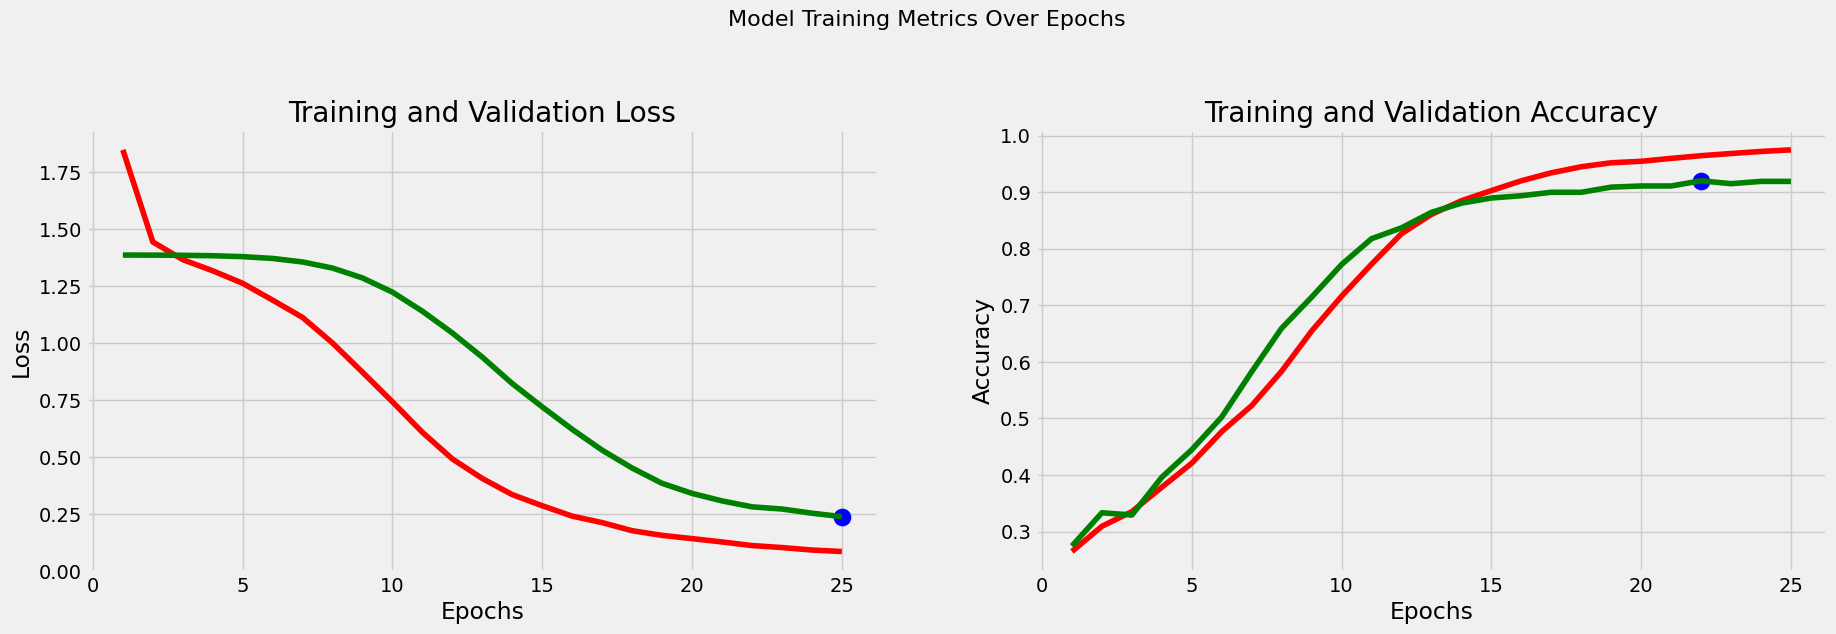

In [117]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'

plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')

plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()

In [110]:
y_true=[]
for i in range(len(ts_y)):

    x = np.argmax(ts_y[i])
    y_true.append(x)

In [111]:
preds = model.predict([ts_x, ts_x])
y_pred = np.argmax(preds, axis=1)
y_pred

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


array([0, 1, 0, 2, 0, 3, 1, 2, 0, 3, 0, 1, 1, 1, 3, 1, 2, 2, 3, 2, 1, 0,
       2, 0, 3, 3, 1, 3, 2, 0, 3, 3, 1, 1, 0, 0, 2, 0, 3, 1, 3, 2, 1, 0,
       0, 2, 1, 3, 1, 2, 0, 3, 0, 2, 2, 2, 1, 1, 3, 2, 0, 1, 3, 3, 1, 2,
       0, 1, 0, 3, 1, 0, 1, 1, 1, 3, 1, 3, 0, 2, 2, 0, 1, 3, 0, 3, 0, 0,
       2, 2, 0, 2, 3, 1, 2, 2, 2, 3, 3, 1, 2, 2, 3, 1, 1, 2, 3, 0, 2, 1,
       1, 2, 0, 0, 3, 1, 3, 3, 0, 2, 2, 1, 0, 0, 1, 0, 1, 0, 0, 1, 2, 1,
       0, 1, 2, 2, 3, 3, 3, 1, 0, 3, 3, 1, 3, 0, 0, 0, 0, 2, 3, 1, 3, 3,
       3, 2, 3, 3, 0, 3, 1, 3, 1, 2, 3, 0, 1, 1, 1, 0, 2, 3, 1, 3, 2, 3,
       2, 2, 1, 2, 0, 0, 2, 0, 2, 0, 3, 3, 2, 2, 2, 1, 1, 3, 3, 2, 3, 1,
       1, 0, 1, 0, 2, 0, 2, 0, 2, 2, 0, 3, 3, 1, 3, 2, 0, 1, 2, 1, 3, 3,
       0, 2, 1, 2, 1, 0, 3, 3, 1, 3, 1, 0, 3, 1, 3, 1, 0, 3, 3, 3, 3, 2,
       0, 3, 1, 3, 2, 0, 1, 2, 0, 0, 3, 1, 1, 2, 1, 3, 0, 3, 0, 0, 3, 2,
       0, 0, 2, 0, 2, 1, 2, 1, 2, 2, 1, 2, 3, 2, 2, 0, 1, 3, 3, 1, 3, 0,
       2, 1, 1, 0, 1, 1, 3, 3, 2, 3, 1, 3, 0, 2, 2,

<Axes: >

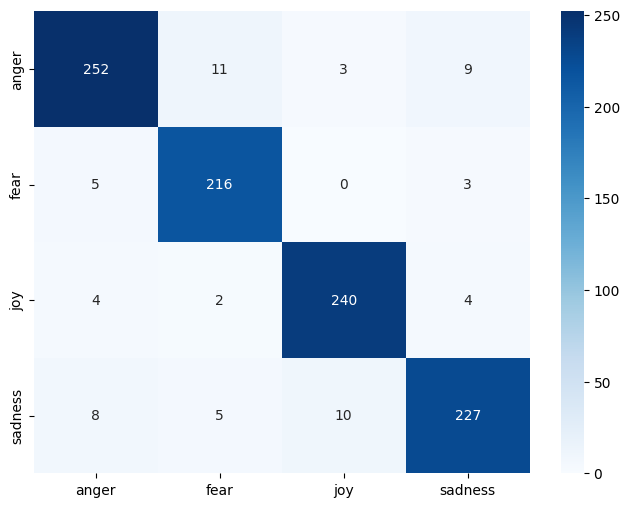

In [112]:
plt.figure(figsize=(8,6))
emotions = {0: 'anger', 1: 'fear', 2: 'joy', 3:'sadness'}
emotions = list(emotions.values())
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotions, yticklabels=emotions)

In [113]:
clr = classification_report(y_true, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.94      0.92      0.93       275
           1       0.92      0.96      0.94       224
           2       0.95      0.96      0.95       250
           3       0.93      0.91      0.92       250

    accuracy                           0.94       999
   macro avg       0.94      0.94      0.94       999
weighted avg       0.94      0.94      0.94       999

